## House Prices: Advanced Regression Techniques

#### Predict sales prices and practice feature engineering, RFs, and gradient boosting
    Lasso regression model (great perform)
    XGBoost model
    LGBM model
        1. install homebrew
        2. brew install libomp
        3. pip install lightgbm
    Dragon model

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print ("Data is loaded!")

Data is loaded!


In [4]:
print ("Train: ",train.shape[0],"sales, and ",train.shape[1],"features")
print ("Test: ",test.shape[0],"sales, and ",test.shape[1],"features")

Train:  1460 sales, and  81 features
Test:  1459 sales, and  80 features


In [5]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [6]:
quantitative

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [7]:
qualitative

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

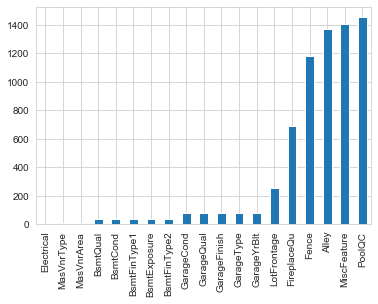

In [8]:
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

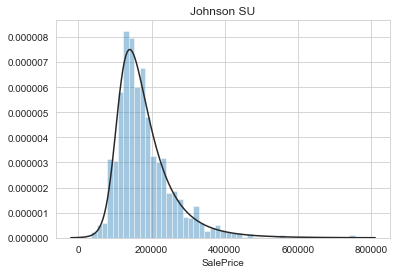

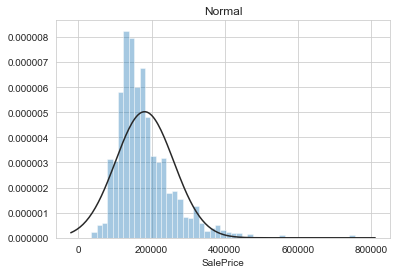

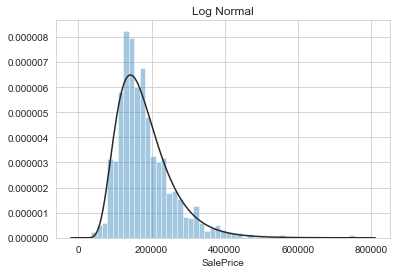

In [9]:
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [10]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


In [11]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [12]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
#spearman(train, features)

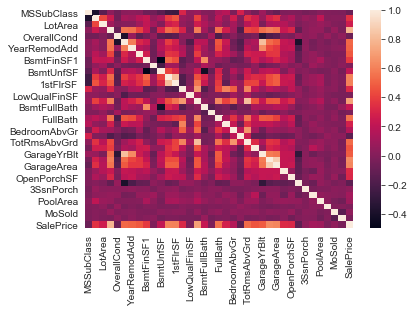

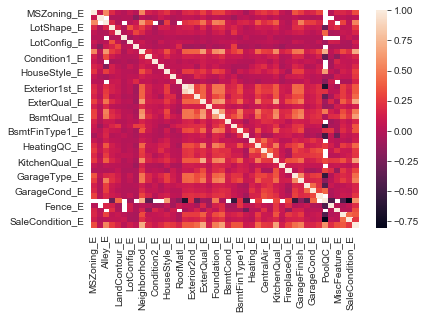

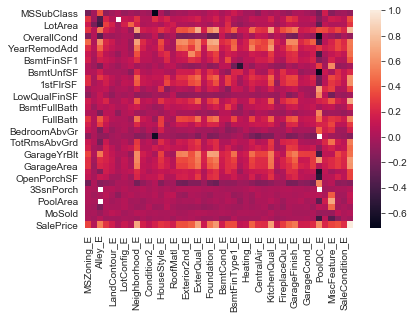

In [13]:
plt.figure(1)
corr = train[quantitative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

## Models

In [14]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [15]:
print(train.shape)
print(test.shape)

(1460, 123)
(1459, 79)


In [16]:
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)

In [17]:
print(train.shape)
train.head

(1458, 123)


<bound method NDFrame.head of       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1453          60       RL         62.0     7917   Pave   NaN      Reg   
1454          20       RL         85.0    13175   Pave   NaN      Reg   
1455          70       RL         66.0     9042   Pave   NaN      Reg   
1456          20       RL         68.0     9717   Pave   NaN      Reg   
1457          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... GarageType_E GarageFinish_E  \
0            Lvl    

In [18]:
print(y.shape)
y.head()

(1458,)


0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

## Features

In [19]:
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [20]:
features.shape

(2917, 122)

In [21]:
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features["PoolQC"] = features["PoolQC"].fillna("None")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

In [22]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,2.0,1.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,2.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0


In [23]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [24]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,2.0,1.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,2.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0


In [25]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [26]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

In [27]:
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [28]:
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [29]:
features.shape

(2917, 129)

In [30]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 376)

In [31]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1458, 376), (1458,), (1459, 376))

In [32]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)

In [33]:
X.shape, y.shape, X_sub.shape

((1453, 375), (1453,), (1459, 375))

In [34]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [35]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [36]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [37]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)   

In [38]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [39]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [40]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [41]:
score = cv_rmse(ridge)
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

LASSO: 0.1005 (0.0147)
 2020-02-23 09:52:17.871615
elastic net: 0.1004 (0.0147)
 2020-02-23 09:53:44.858801
SVR: 0.1009 (0.0116)
 2020-02-23 09:53:57.862037
lightgbm: 0.1057 (0.0151)
 2020-02-23 09:54:18.527114
gbr: 0.1089 (0.0140)
 2020-02-23 09:56:39.223706
[09:56:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:58:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:59:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:02:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:03:20] WARNING: src/objective/regression

In [42]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
[10:10:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:11:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:14:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:15:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:17:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
elasticnet
Lasso
Ridge
Svr
GradientBoosting
xgboost
[10:19:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [43]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [45]:
print('RMSLE score on train data:')
score = rmsle(y, blend_models_predict(X))
print(score)

RMSLE score on train data:
0.05359154280418588


In [46]:
print('Predict submission')
submission = pd.read_csv("./data/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))
submissionssion.to_csv(f"./Score_{score:.5f}_submission.csv", index=False)



Predict submission


In [47]:
submission.head()

,Id,SalePrice
0,1461,61721.0
1,1462,69425.0
2,1463,87117.0
3,1464,92057.0
4,1465,84645.0


In [49]:
from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor

In [50]:
# Based on https://www.kaggle.com/hemingwei/top-2-from-laurenstc-on-house-price-prediction

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print("Train set size:", train.shape)
print("Test set size:", test.shape)
print('START data processing', datetime.now(), )

train_ID = train['Id']
test_ID = test['Id']
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

# Deleting outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

features["PoolQC"] = features["PoolQC"].fillna("None")

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

# simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

print(features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print(final_features.shape)

X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

# ################## ML ########################################
print('START ML', datetime.now(), )

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)


# setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, l1_ratio=e_l1ratio))
                                        
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
                                   

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )
                                       

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

# stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)
                                

print('TEST score on CV')

score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


print('START Fit')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

Train set size: (1460, 81)
Test set size: (1459, 80)
START data processing 2020-02-23 11:29:37.156873
(2917, 79)
(2917, 86)
(2917, 333)
X (1458, 333) y (1458,) X_sub (1459, 333)
X (1453, 331) y (1453,) X_sub (1459, 331)
START ML 2020-02-23 11:29:38.285308
TEST score on CV
Kernel Ridge score: 0.1024 (0.0143)
 2020-02-23 11:29:58.824313
Lasso score: 0.1031 (0.0147)
 2020-02-23 11:30:16.710903
ElasticNet score: 0.1031 (0.0149)
 2020-02-23 11:31:33.721369
SVR score: 0.1023 (0.0133)
 2020-02-23 11:31:45.524012
Lightgbm score: 0.1067 (0.0153)
 2020-02-23 11:32:04.750322
GradientBoosting score: 0.1073 (0.0138)
 2020-02-23 11:34:27.594448
[11:34:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:36:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:37:45] WA

In [ ]:
# Brutal approach to deal with predictions close to outer range 
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)

submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

submission.to_csv("./new_submission.csv", index=False)
print('Save submission', datetime.now(),)